# モジュールのインポート


In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import chainer

# ネットワークの構築

## データセットのインストール

In [10]:
from chainer.datasets.fashion_mnist import get_fashion_mnist

# データセットがダウンロード済みでなければ、ダウンロードも行う
train, test = get_fashion_mnist(withlabel=True, ndim=1)

## 訓練データの学習用と検証用の分割

In [11]:
train, validation = chainer.datasets.split_dataset_random(train, 50000, seed=0)

## ネットワークの構築

### シンプルなMLP

In [14]:
import chainer.functions as F
import chainer.links as L
from chainer import Chain
## 3-layer multi-Layer Perceptron (MLP)
class MLP3(Chain):
    def __init__(self):
        super(MLP3, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(784, 200)
            self.l2=L.Linear(200, 200)   # Additional  layer
            self.l3=L.Linear(200, 10)

    def forward(self, x):
        h1 = F.tanh(self.l1(x))   # Hidden unit 1
        h2 = F.tanh(self.l2(h1)) # Hidden unit 2
        y = self.l3(h2)
        return y

### シンプルなCNN

In [15]:
import chainer.functions as F
import chainer.links as L
from chainer import Chain

class ConvNet(Chain):
    def __init__(self):
        super(ConvNet, self).__init__()
        with self.init_scope():
            # all pads are 0 -> 1
            self.conv1 = L.Convolution2D(
                in_channels=None, out_channels=32, ksize=3, stride=1, pad=1)  # 6 -> 32
            self.conv2 = L.Convolution2D(
                in_channels=None, out_channels=64, ksize=3, stride=1, pad=1) # 16 -> 64
            self.conv3 = L.Convolution2D(
                in_channels=None, out_channels=128, ksize=3, stride=1, pad=1) # 120 -> 128
            self.conv4 = L.Convolution2D(
                in_channels=None, out_channels=128, ksize=3, stride=1, pad=1) # new layer
            self.fc5 = L.Linear(None, 1000) # 84 -> 1000
            self.fc6 = L.Linear(None, 10)

    def forward(self, x):
        h = F.relu(self.conv1(x.reshape((-1, 1, 28, 28))))
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.relu(self.conv2(h))  # sigmoid -> relu
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.relu(self.conv3(h))  # sigmoid -> relu
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.relu(self.conv4(h))  # sigmoid -> relu
        h = F.relu(self.fc5(h))  # sigmoid -> relu
        return self.fc6(h)

### DropOutを用いたCNN

In [16]:
class ConvNet_withDropOut(Chain):
    def __init__(self):
        super(ConvNet_withDropOut, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(
                in_channels=None, out_channels=32, ksize=3, stride=1, pad=1)
            self.conv2 = L.Convolution2D(
                in_channels=None, out_channels=64, ksize=3, stride=1, pad=1)
            self.conv3 = L.Convolution2D(
                in_channels=None, out_channels=128, ksize=3, stride=1, pad=1)
            self.conv4 = L.Convolution2D(
                in_channels=None, out_channels=128, ksize=3, stride=1, pad=1)
            self.fc5 = L.Linear(None, 2000) # 1000 -> 2000
            self.fc6 = L.Linear(None, 10)

    def __call__(self, x):
        h = F.dropout(F.relu(self.conv1(x.reshape((-1, 1, 28, 28)))), ratio=0.2)  # add dropout
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.dropout(F.relu(self.conv2(h)), ratio=0.2)  # add dropout
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.dropout(F.relu(self.conv3(h)), ratio=0.2)  # add dropout
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        h = F.dropout(F.relu(self.conv4(h)))  # add dropout
        h = F.dropout(F.relu(self.fc5(h)))  # add dropout
        return self.fc6(h)

## 訓練環境の構築

In [17]:
from chainer import optimizers, training
from chainer.training import extensions

def  train_and_validate(
        model, optimizer, train, validation, n_epoch, batchsize, device=0):
    
    # 1. deviceがgpuであれば、gpuにモデルのデータを転送する
    if device >= 0:
        model.to_gpu(device)
        
    # 2. Optimizerを設定する
    optimizer.setup(model)
    
    # 3. DatasetからIteratorを作成する
    train_iter = chainer.iterators.SerialIterator(train, batchsize)
    validation_iter = chainer.iterators.SerialIterator(
        validation, batchsize, repeat=False, shuffle=False)
    
    # 4. Updater・Trainerを作成する
    updater = training.StandardUpdater(train_iter, optimizer, device=device)
    trainer = chainer.training.Trainer(updater, (n_epoch, 'epoch'), out='out')
    
    # 5. Trainerの機能を拡張する
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.Evaluator(validation_iter, model, device=device), name='val')
    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(
        ['main/loss', 'val/main/loss'],x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(
        ['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
    trainer.extend(extensions.dump_graph('main/loss'))
    
    # 6. 訓練を開始する
    trainer.run()

In [18]:
device = -1 #cpuの指定
n_epoch = 10
batchsize = 128

model = MLP3()
classifier_model = L.Classifier(model)
optimizer = optimizers.Adam()
train_and_validate(classifier_model, optimizer, train, validation, n_epoch, batchsize, device)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           0.513672    0.816476       0.43569        0.841574           6.57622       
2           0.384243    0.860074       0.38276        0.859968           13.6507       
3           0.345206    0.874499       0.353975       0.86966            18.3994       
4           0.319444    0.882773       0.346406       0.87322            23.3118       
5           0.302314    0.889526       0.34248        0.872923           28.022        
6           0.285312    0.895212       0.346405       0.870945           32.9101       
7           0.27067     0.899457       0.313579       0.88301            37.7046       
8           0.257499    0.905128       0.323638       0.881131           42.5597       
9           0.245816    0.909347       0.311018       0.885977           47.2563       
10          0.238643    0.910226       0.318195       0.884395           51.9796       


In [19]:
def show_graph():
    graph = pydot.graph_from_dot_file('out/cg.dot') # load from .dot file
    graph[0].write_png('graph.png')
    display(Image('graph.png', width=600, height=600))

In [27]:
import pydot
from IPython.display import Image, display
def show_loss_and_accuracy():
    display(Image(filename='out/loss.png'))
    display(Image(filename='out/accuracy.png'))

In [21]:
def show_test_performance(model, test, device, batchsize=256):
    if device >=0:
        model.to_gpu()
    test_iter = chainer.iterators.SerialIterator(
        test, batchsize, repeat=False, shuffle=False
    )
    test_evaluator = extensions.Evaluator(test_iter, model, device=device)
    results = test_evaluator()
    print('Test accuracy:', results['main/accuracy'])

In [23]:
show_test_performance(classifier_model, test, device = -1)

Test accuracy: 0.8802734375


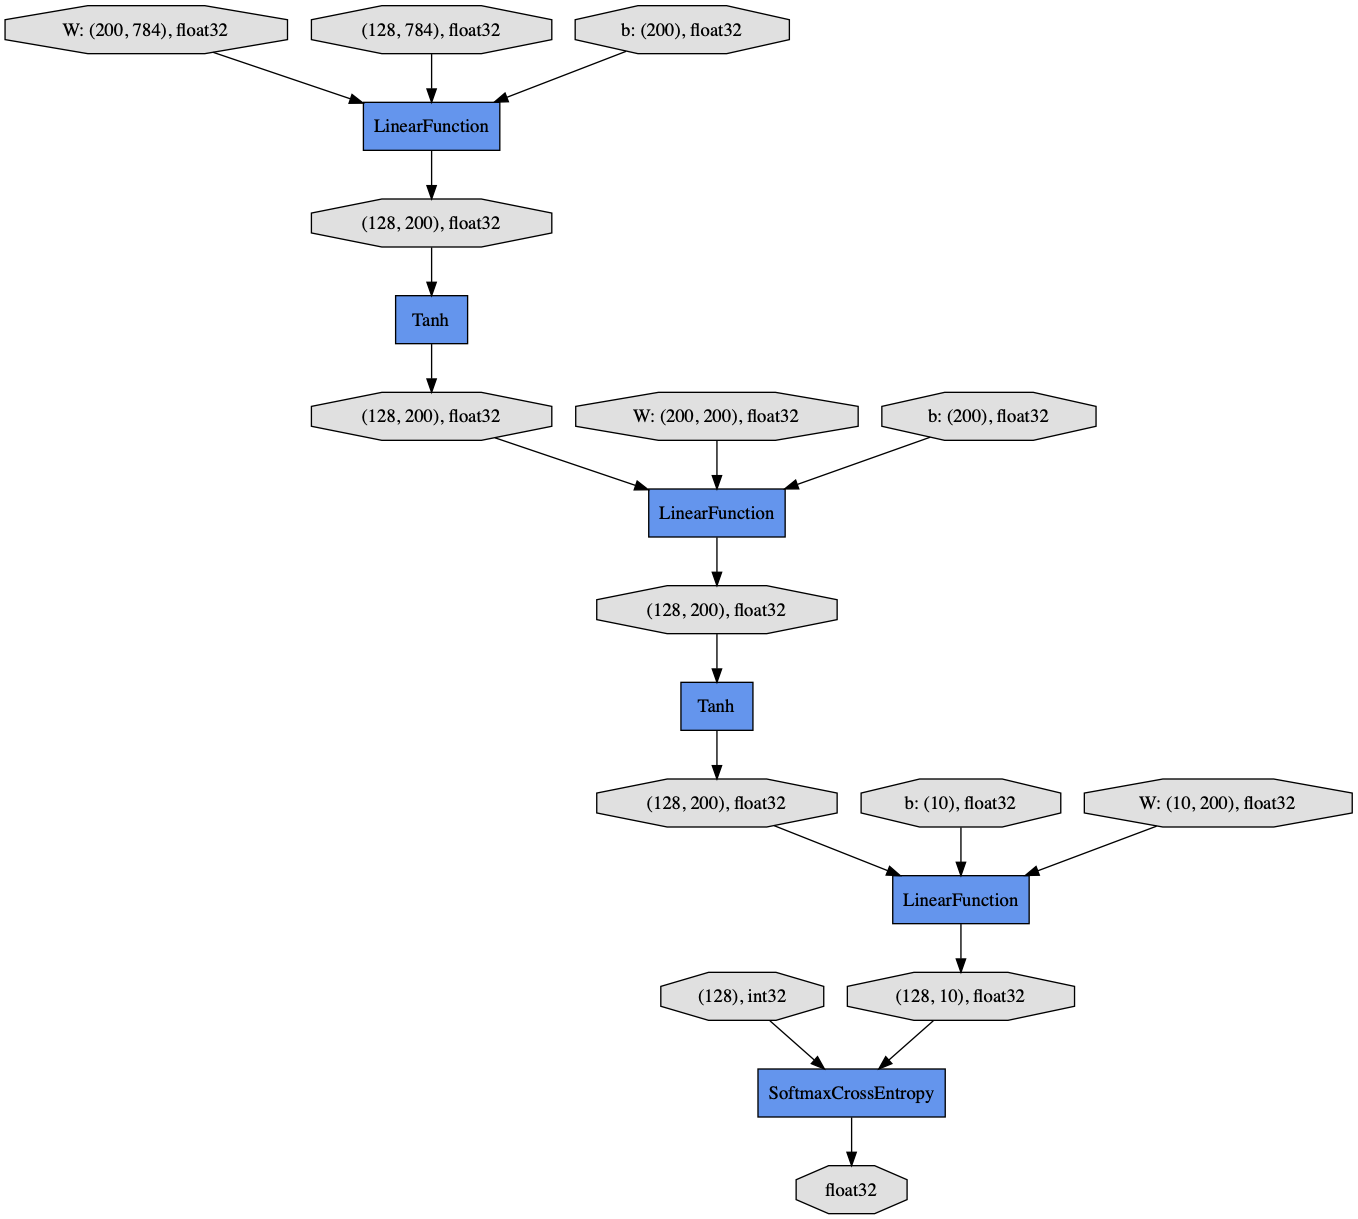

In [28]:
show_graph()

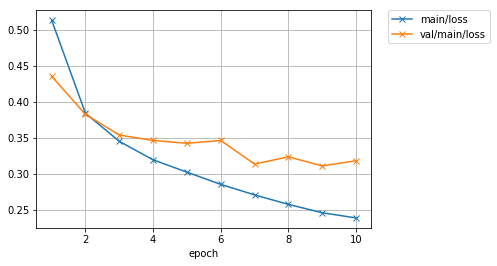

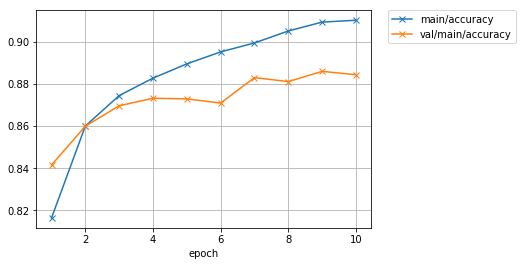

In [29]:
show_loss_and_accuracy()

In [31]:
device = -1
n_epoch = 10
batchsize = 128

model = ConvNet()
classifier_model = L.Classifier(model)
optimizer = optimizers.Adam()
train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, batchsize, device)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           0.473278    0.823809       0.351574       0.86788            443.17        
2           0.286877    0.893842       0.272319       0.901305           980.468       
3           0.238003    0.91224        0.256608       0.906151           1593.53       
4           0.205099    0.924153       0.249782       0.911887           2151.33       
5           0.180154    0.932745       0.262218       0.909909           2700.69       
6           0.152939    0.941907       0.252657       0.910601           3196.42       
7           0.135002    0.949089       0.285153       0.909415           3623.96       
8           0.112371    0.957071       0.290873       0.907634           4021.6        
9           0.102155    0.960718       0.277539       0.917128           4380.5        
10          0.0852959   0.96843        0.318417       0.904371           4778.97       


In [33]:
show_test_performance(classifier_model, test, device)

Test accuracy: 0.90546875


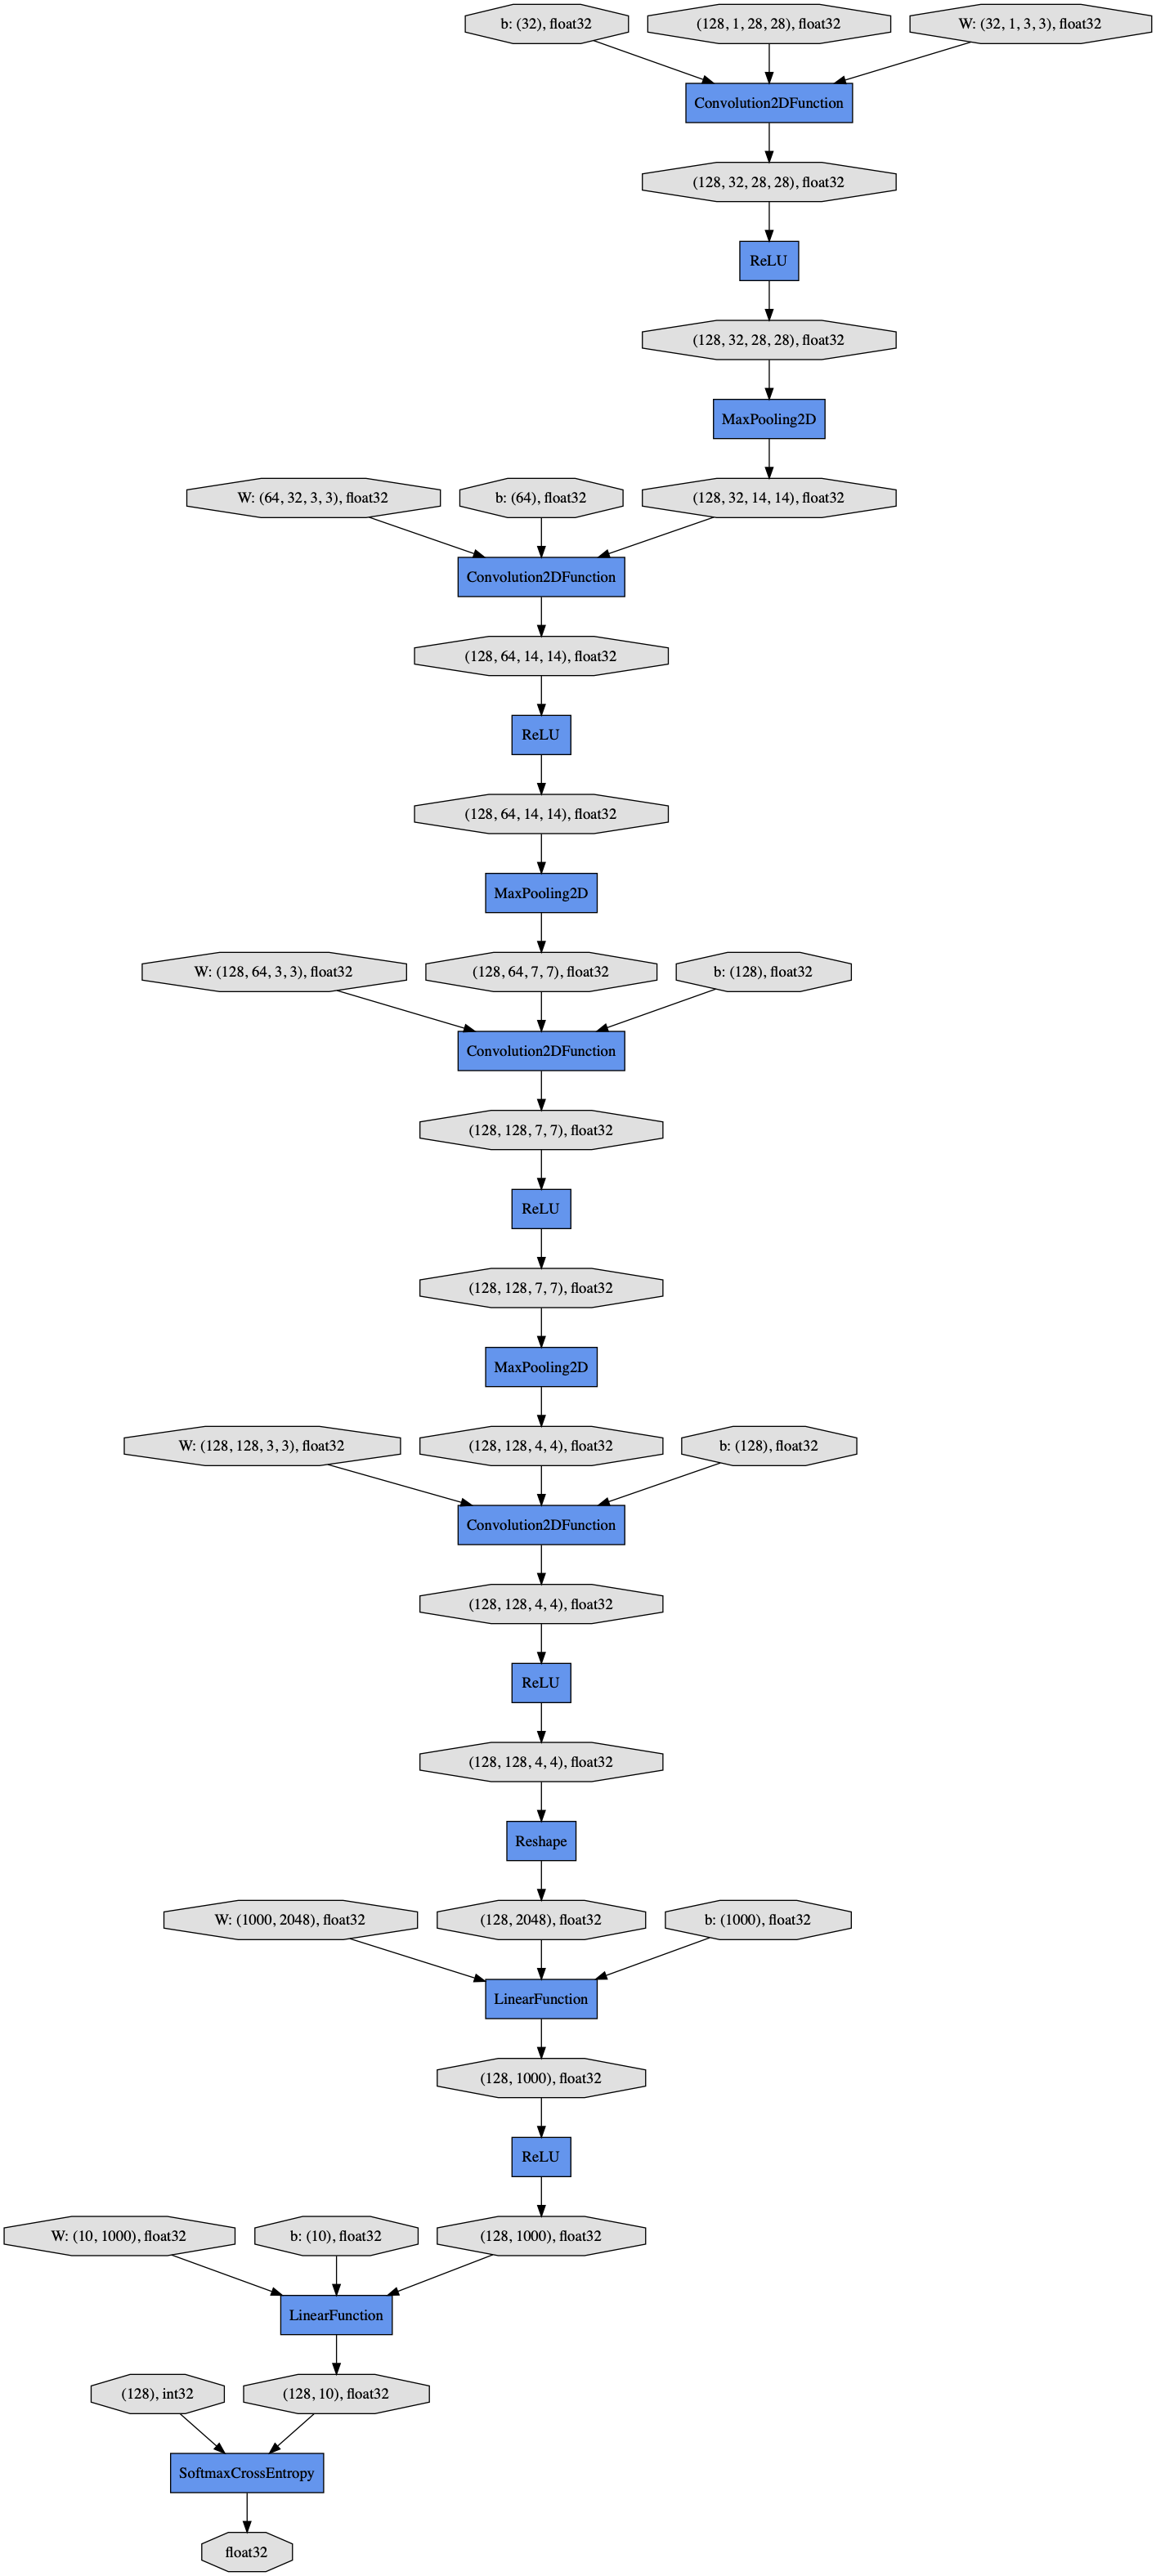

In [34]:
show_graph()

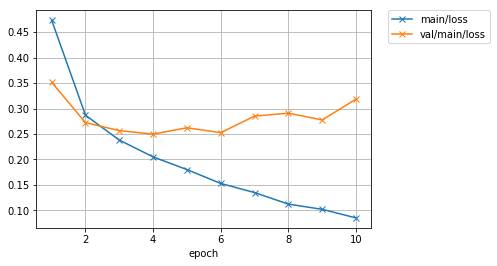

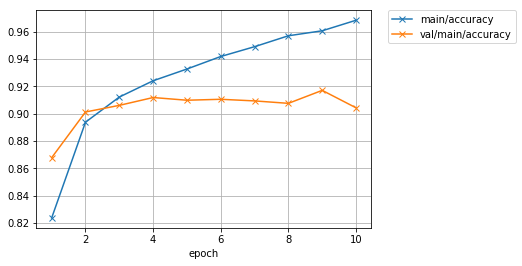

In [35]:
show_loss_and_accuracy()

In [37]:
device = -1
n_epoch = 10
batchsize = 128

model = ConvNet_withDropOut()
classifier_model = L.Classifier(model)
optimizer = optimizers.Adam()
train_and_validate(
    classifier_model, optimizer, train, validation, n_epoch, batchsize, device)

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           0.550837    0.795376       0.413028       0.860265           577.353       
2           0.355638    0.870344       0.315907       0.88479            1418.15       
3           0.312855    0.884034       0.287309       0.897943           2280.45       
4           0.28062     0.893942       0.269995       0.900514           2840.83       
5           0.261186    0.902833       0.257005       0.904371           3308.53       
6           0.253011    0.90641        0.239098       0.911096           3762.38       
7           0.237231    0.913443       0.249847       0.90803            4197.57       
8           0.226131    0.915625       0.233791       0.913172           4813.79       
9           0.218371    0.918079       0.239545       0.909612           5378.23       
10          0.208963    0.921675       0.22358        0.918513           5890.38       


In [39]:
show_test_performance(classifier_model, test, device)

Test accuracy: 0.91611328125


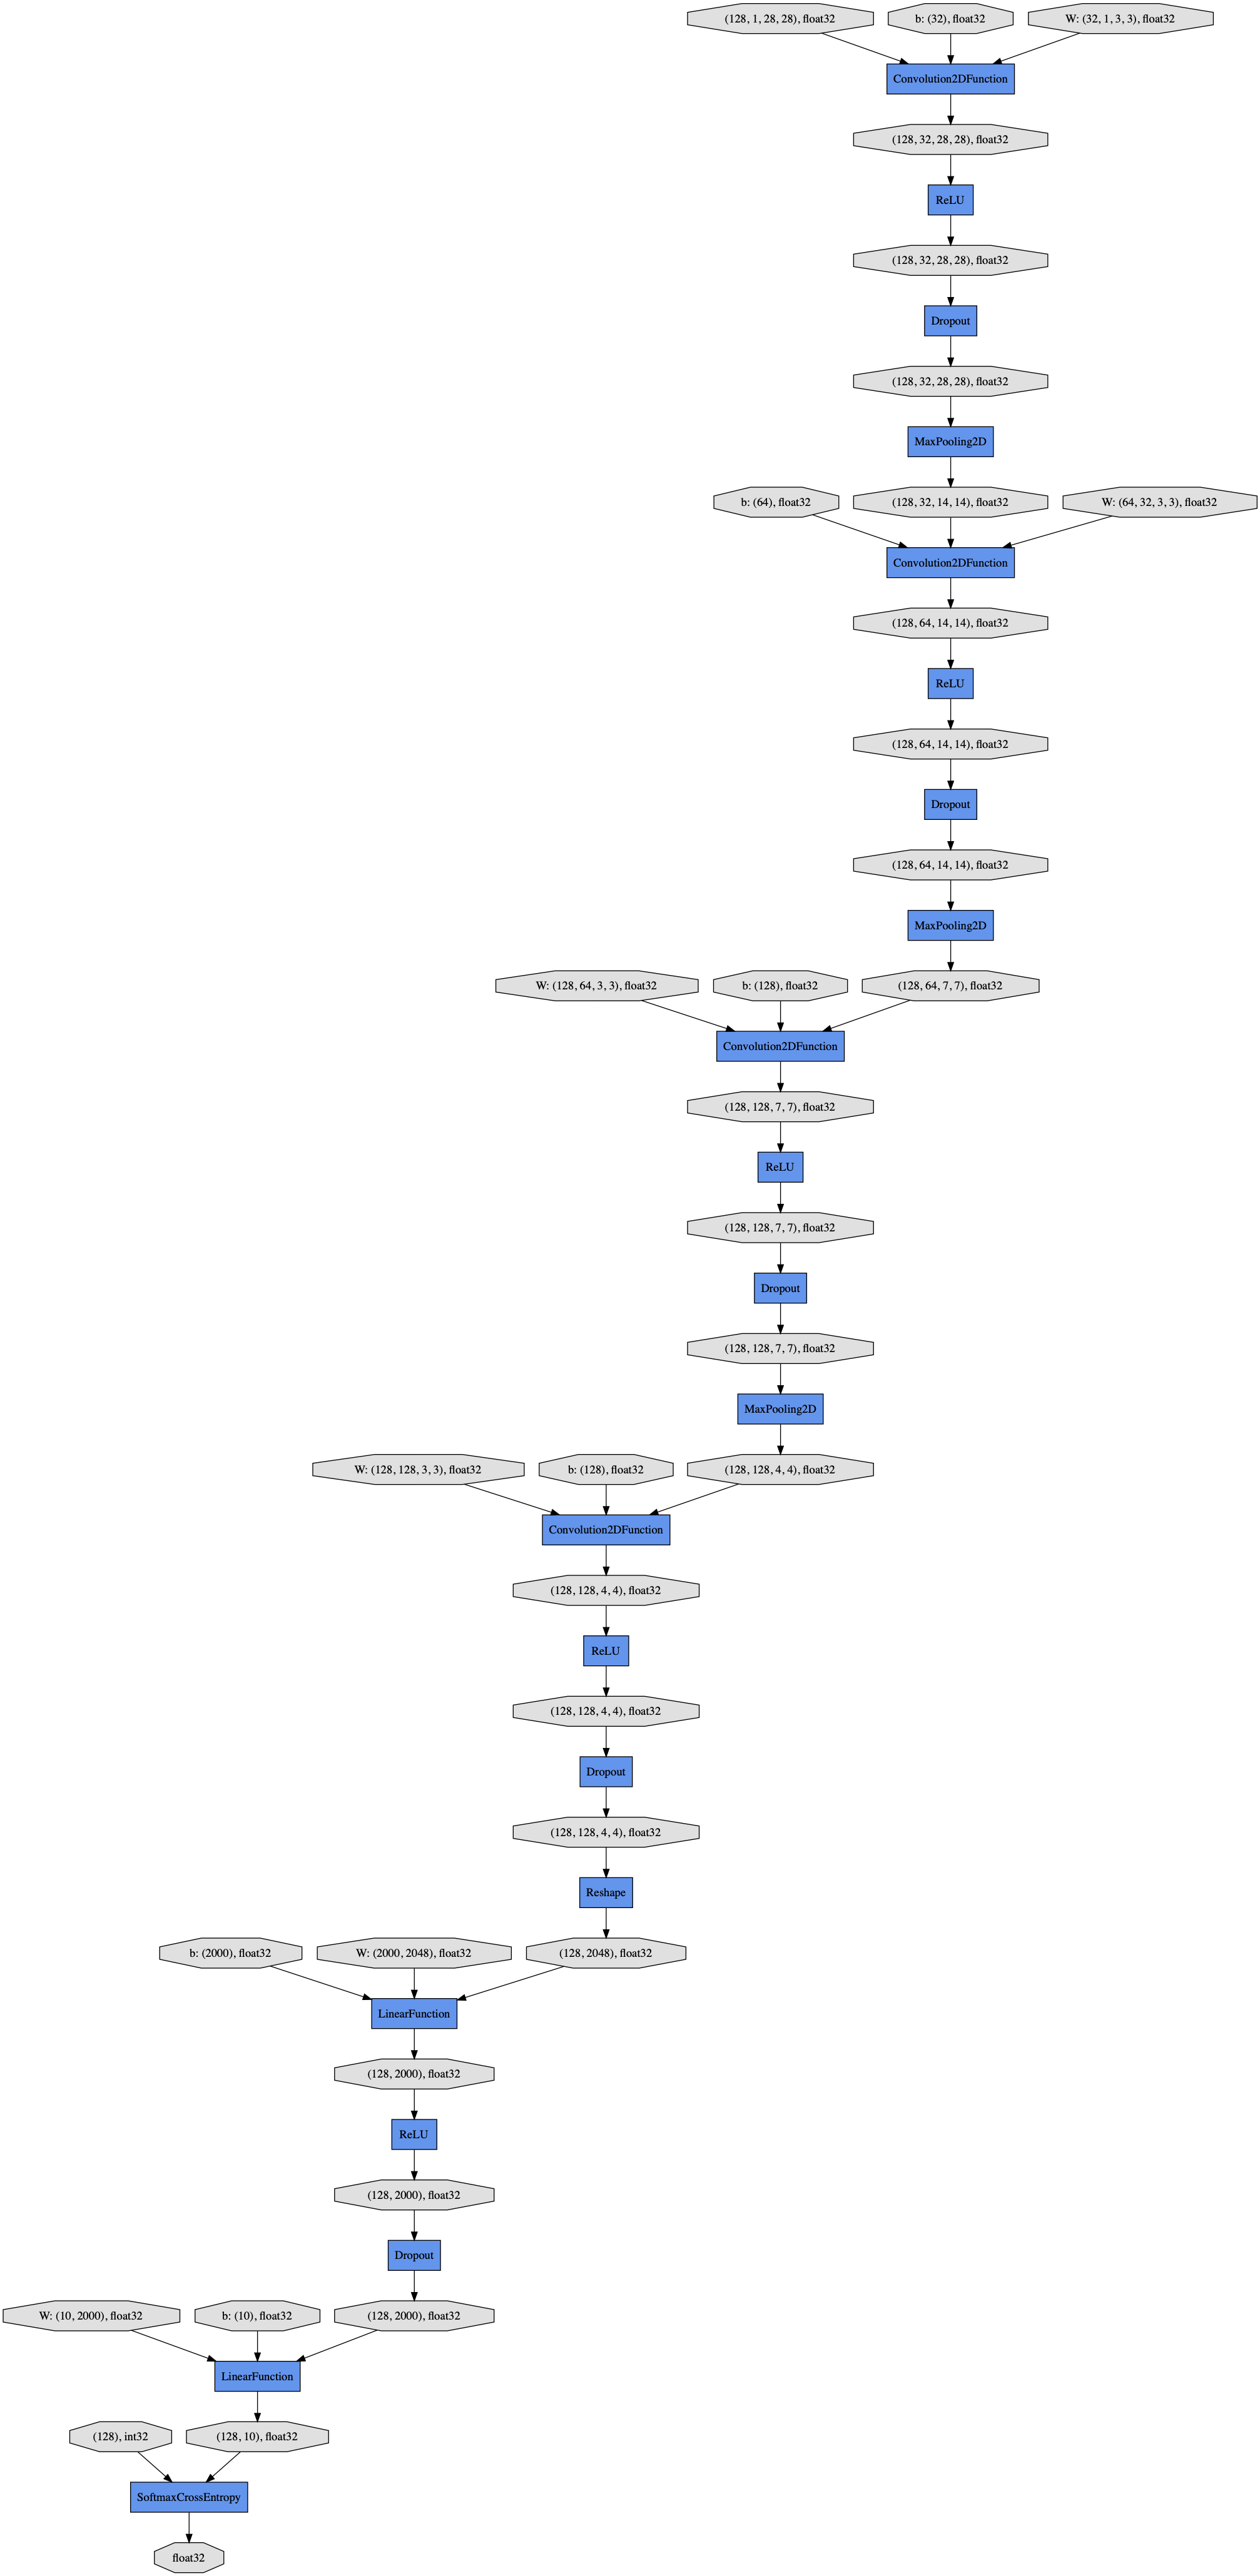

In [40]:
show_graph()

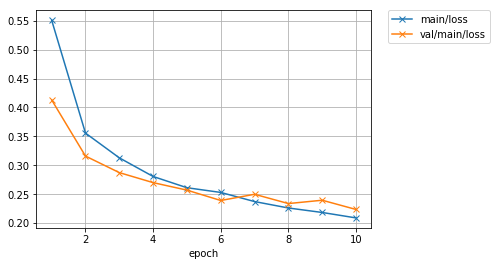

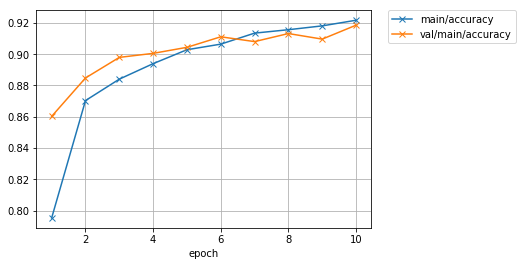

In [41]:
show_loss_and_accuracy()